# Impact of Data Augmentation and Batch Normalization

## Initialization

In [1]:
# Load libraries

# OS
import os

# Data manipulation, visualization and model building
import torchvision.models as models
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from torch_snippets import *

!nvidia-smi # check if GPU is available
%matplotlib inline

zsh:1: command not found: nvidia-smi


In [2]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu

In [3]:
# Download the dataset
root_dir = 'data/GTSRB/'

import os
if not os.path.exists(root_dir):
    !mkdir -p {root_dir}
    !cd {root_dir} && wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !cd {root_dir} && wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !cd {root_dir} && unzip -qq GTSRB_Final_Training_Images.zip
    !cd {root_dir} && unzip -qq GTSRB_Final_Test_Images.zip
    !cd {root_dir} && wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !cd {root_dir} && rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

--2024-02-20 16:36:33--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[2606:50c0:8000::154]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 999 [text/plain]
Grabando a: «signnames.csv»

signnames.csv       100%[===================>]     999  --.-KB/s    en 0s      

2024-02-20 16:36:34 (56.0 MB/s) - «signnames.csv» guardado [999/999]



In [100]:
# Get class indexes and names
classIds = pd.read_csv(f'{root_dir}signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']

# Reverse the dictionary
int2id = {v: k for k, v in classIds.items()}

# Add leading zeros to the keys
classIds = {f'{k:05d}':v for k,v in classIds.items()}

# Print the first 5 items of both dictionaries
print({k: classIds[k] for k in list(classIds)[:5]})
print({k: int2id[k] for k in list(int2id)[:5]})

{
    '00000': 'Speed limit (20km/h)',
    '00001': 'Speed limit (30km/h)',
    '00002': 'Speed limit (50km/h)',
    '00003': 'Speed limit (60km/h)',
    '00004': 'Speed limit (70km/h)'
}

{
    'Speed limit (20km/h)': 0,
    'Speed limit (30km/h)': 1,
    'Speed limit (50km/h)': 2,
    'Speed limit (60km/h)': 3,
    'Speed limit (70km/h)': 4
}

In [36]:
# Create tranformations pipeline for input images
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    ### Data augmentation ---> Overfitting decreased
    T.ColorJitter(brightness=(0.8,1.2), 
    contrast=(0.8,1.2), 
    saturation=(0.8,1.2), 
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    ###
    T.ToTensor(), # Get values between 0 and 1
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize to the ImageNet mean and standard deviation
])

# Create tranformations pipeline for validation images
val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(), # Get values between 0 and 1
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize to the ImageNet mean and standard deviation
])

In [37]:
# Create Dataset class to fetch images and labels
class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        image = read(file_path, 1)
        label_idx = fname(parent(file_path))
        return image, classIds[label_idx]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        images, classes = list(zip(*batch))
        if self.transform:
            images = [self.transform(img)[None] for img in images]
        classes = [torch.tensor([int2id[clss]]) for clss in classes]
        images, classes = [torch.cat(idx).to(device) for idx in [images, classes]]
        return images, classes

In [38]:
# Get the list of files
files = Glob(f'{root_dir}GTSRB/Final_Training/Images/*/*.ppm')
print(f'Found {len(files)} files')

# Shuffle the files
np.random.shuffle(files)

# Get the train and validation files
train_files, val_files = train_test_split(files, test_size=0.2, random_state=4)

# Create the train and validation datasets
train_ds = GTSRB(train_files, transform=train_transforms)
val_ds = GTSRB(val_files, transform=val_transforms)

Found 39209 files

[02/20/24 18:44:04] INFO     31367                                                                                                                  ]8;id=564759;file:///var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_14337/3718259482.py:8\3718259482.py]8;;\:]8;id=364893;file:///var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_14337/3718259482.py:8#__init__:8\__init__:8]8;;\

                    INFO     7842                                                                                                                   ]8;id=187562;file:///var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_14337/3718259482.py:8\3718259482.py]8;;\:]8;id=162134;file:///var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_14337/3718259482.py:8#__init__:8\__init__:8]8;;\

In [39]:
# Create a function to retrieve the dataloaders
def load_data(batch_size):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=val_ds.collate_fn)

    return train_dl, val_dl

In [40]:
# Create a function to define a Convolutional Block
def convBlock(n_inputs, n_outputs):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(n_inputs, n_outputs, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(n_outputs), # Batch Normalization improved around 3% the accuracy
        nn.MaxPool2d(2),
    )

# Create a class to define the Road Sign classifier model
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(int2id))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.argmax(preds, 1) == targets).float().mean()
        return ce_loss, acc

In [41]:
# Create a function to train the model on a batch of data
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    images, labels = data
    _preds = model(images)
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, labels = data
    _preds = model(images)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

EPOCH: 1.000  train_loss: 1.809  val_loss: 0.883  val_acc: 0.738  train_acc: 0.465  (114.17s - 5594.47s remaining)
EPOCH: 2.000  train_loss: 0.664  val_loss: 0.959  val_acc: 0.762  train_acc: 0.786  (222.47s - 5339.31s remaining)
EPOCH: 3.000  train_loss: 0.472  val_loss: 0.503  val_acc: 0.848  train_acc: 0.848  (333.14s - 5219.23s remaining)
EPOCH: 4.000  train_loss: 0.376  val_loss: 0.425  val_acc: 0.870  train_acc: 0.877  (447.23s - 5143.09s remaining)
EPOCH: 5.000  train_loss: 0.326  val_loss: 0.323  val_acc: 0.906  train_acc: 0.894  (562.11s - 5058.95s remaining)
EPOCH: 6.000  train_loss: 0.277  val_loss: 0.406  val_acc: 0.892  train_acc: 0.907  (670.55s - 4917.35s remaining)
EPOCH: 7.000  train_loss: 0.264  val_loss: 0.443  val_acc: 0.874  train_acc: 0.916  (783.12s - 4810.62s remaining)
EPOCH: 8.000  train_loss: 0.240  val_loss: 0.443  val_acc: 0.881  train_acc: 0.919  (896.75s - 4707.93s remaining)
EPOCH: 9.000  train_loss: 0.223  val_loss: 0.325  val_acc: 0.914  train_acc: 0.9

100%|██████████| 151/151 [00:01<00:00, 138.56it/s]


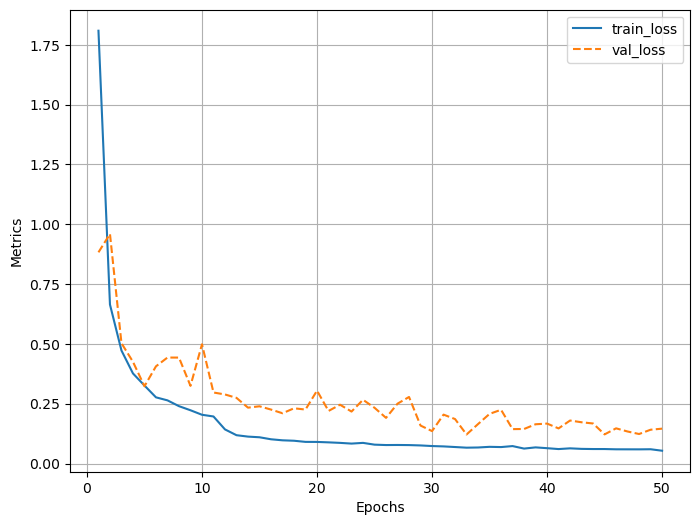

In [42]:
# Train the model
model = SignClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
critertion = model.compute_metrics
train_dl, val_dl = load_data(batch_size=32)
n_epochs = 50
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, critertion)
        log.record(epoch+(i+1)/n, train_loss=loss, train_acc=acc, end='\r')
    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, critertion)
        log.record(epoch+(i+1)/n, val_loss=loss, val_acc=acc, end='\r')
    log.report_avgs(epoch+1)
    if epoch == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)
log.plot_epochs(['train_loss', 'val_loss'])

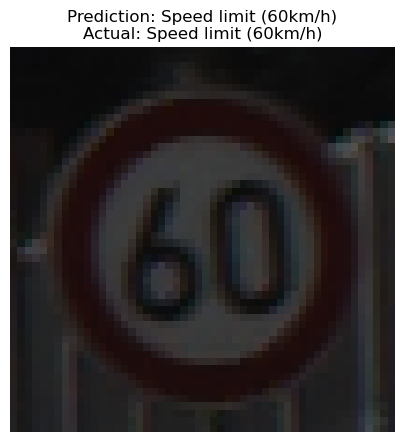

In [115]:
# Make a prediction and plot the result

# Reverse the dictionary
_int2id = {int(v): k  for k, v in int2id.items()}

# Get a random image and label
_image, label = val_ds.choose()

# Preprocess the image
image = val_transforms(_image)[None].to(device)

# Make the prediction
pred = model(image)
pred = _int2id[torch.argmax(pred, 1).item()]
show(_image, title=f'Prediction: {pred}\nActual: {label}', sz=5)